# Veri Seti Hikayesi
* Pregnancies : Hamilelik
* Glucose :     Vücuttaki glikoz değeri
* BloodPressure: Tansiyon
* Skin Thickness : Cilt Kalınlığı
* Insulin : İnsülin değeri
* BMI : Vücut kitle indexi (Vücut Kitle İndeksi (VKİ) = Vücut Ağırlığı (kg.) / Boy uzunluğunun karesi (m.))
* DiabetesPedigreeFunction :Diyabet soyağacı fonksiyonu (aile geçmişine dayalı diyabet olasılığını puanlayan bir fonksiyon)
* Age : Yaş 
* Outcome: Sonuç

In [1]:
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold

In [2]:
import warnings
warnings.simplefilter(action = "ignore") 

# PROJE 4: Şeker Hastalığı Tahmini

In [3]:
df1 = pd.read_csv("diabetes.csv")

In [4]:
df1.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df = df1.copy()
df.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0


In [6]:
df[["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]] = df[["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]].replace(0,np.NaN)

In [7]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [10]:
pd.set_option('display.max_rows', df.shape[0]+1)
df.groupby("Outcome").describe().T

Outcome                                  0           1
Pregnancies              count  500.000000  268.000000
                         mean     3.298000    4.865672
                         std      3.017185    3.741239
                         min      0.000000    0.000000
                         25%      1.000000    1.750000
                         50%      2.000000    4.000000
                         75%      5.000000    8.000000
                         max     13.000000   17.000000
Glucose                  count  497.000000  266.000000
                         mean   110.643863  142.319549
                         std     24.776906   29.599199
                         min     44.000000   78.000000
                         25%     93.000000  119.000000
                         50%    107.000000  140.000000
                         75%    125.000000  167.000000
                         max    197.000000  199.000000
BloodPressure            count  481.000000  252.000000
                         mean    70.877339   75.321429
                         std     12.161223   12.299866
                         min     24.000000   30.000000
                         25%     62.000000   68.000000
                         50%     70.000000   74.500000
                         75%     78.000000   84.000000
                         max    122.000000  114.000000
SkinThickness            count  361.000000  180.000000
                         mean    27.235457   33.000000
                         std     10.026491   10.327595
                         min      7.000000    7.000000
                         25%     19.000000   27.000000
                         50%     27.000000   32.000000
                         75%     33.000000   39.000000
                         max     60.000000   99.000000
Insulin                  count  264.000000  130.000000
                         mean   130.287879  206.846154
                         std    102.482237  132.699898
                         min     15.000000   14.000000
                         25%     66.000000  127.500000
                         50%    102.500000  169.500000
                         75%    161.250000  239.250000
                         max    744.000000  846.000000
BMI                      count  491.000000  266.000000
                         mean    30.859674   35.406767
                         std      6.560737    6.614982
                         min     18.200000   22.900000
                         25%     25.600000   30.900000
                         50%     30.100000   34.300000
                         75%     35.300000   38.925000
                         max     57.300000   67.100000
DiabetesPedigreeFunction count  500.000000  268.000000
                         mean     0.429734    0.550500
                         std      0.299085    0.372354
                         min      0.078000    0.088000
                         25%      0.229750    0.262500
                         50%      0.336000    0.449000
                         75%      0.561750    0.728000
                         max      2.329000    2.420000
Age                      count  500.000000  268.000000
                         mean    31.190000   37.067164
                         std     11.667655   10.968254
                         min     21.000000   21.000000
                         25%     23.000000   28.000000
                         50%     27.000000   36.000000
                         75%     37.000000   44.000000
                         max     81.000000   70.000000

In [11]:
#Eksik değerleri medyan ile doldurduk
def median_target(sfy):   
    temp = df[df[sfy].notnull()]
    temp = temp[[sfy, 'Outcome']].groupby(['Outcome'])[[sfy]].median().reset_index()
    return temp

In [12]:
# Eksik gözlemler için verilecek değerlere, hasta olmayanların medyan değeri ve hasta olanların medyan değerleri verilmiştir.
columns = df.columns
columns = columns.drop("Outcome")
for i in columns:
    median_target(i)
    df.loc[(df['Outcome'] == 0 ) & (df[i].isnull()), i] = median_target(i)[i][0]
    df.loc[(df['Outcome'] == 1 ) & (df[i].isnull()), i] = median_target(i)[i][1]

In [13]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [14]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [15]:
for feature in df:
    
    Q1 = df[feature].quantile(0.05)
    Q3 = df[feature].quantile(0.95)
    IQR = Q3-Q1
    lower = Q1- 1.5*IQR
    upper = Q3 + 1.5*IQR
    
    if df[(df[feature] > upper)].any(axis=None):
        print(feature,"yes")
    else:
        print(feature, "no")

Pregnancies no
Glucose no
BloodPressure no
SkinThickness yes
Insulin yes
BMI no
DiabetesPedigreeFunction no
Age no
Outcome no


In [16]:
Q1 = df["Insulin"].quantile(0.05)
Q3 = df["Insulin"].quantile(0.95)
IQR = Q3-Q1
upper = Q3 + 1.5*IQR

In [17]:
upper

657.5

In [18]:
df[df["Insulin"] > upper]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
13,1,189.0,60.0,23.0,846.0,30.1,0.398,59,1
228,4,197.0,70.0,39.0,744.0,36.7,2.329,31,0
247,0,165.0,90.0,33.0,680.0,52.3,0.427,23,0


In [19]:
df.loc[df["Insulin"] > upper, "Insulin"] = upper

In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,121.677083,30.464161,44.000,99.75000,117.0000,140.25000,199.00
BloodPressure,768.0,72.389323,12.106039,24.000,64.00000,72.0000,80.00000,122.00
SkinThickness,768.0,29.089844,8.890820,7.000,25.00000,28.0000,32.00000,99.00
Insulin,768.0,141.366536,86.498435,14.000,102.50000,102.5000,169.50000,657.50
BMI,768.0,32.434635,6.880498,18.200,27.50000,32.0500,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [21]:
# LOF yöntemi ile tüm değişkenler arasındaki uç değerleri belirleriz
from sklearn.neighbors import LocalOutlierFactor
lof =LocalOutlierFactor(n_neighbors= 10)
lof.fit_predict(df)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1

In [22]:
df_scores = lof.negative_outlier_factor_
np.sort(df_scores)[0:30]

array([-3.05893469, -2.37289269, -2.15297995, -2.09708735, -2.0772561 ,
       -1.95255968, -1.86384019, -1.74003158, -1.72703492, -1.71674689,
       -1.70343883, -1.6688722 , -1.64296768, -1.64190437, -1.62400416,
       -1.61748009, -1.61620872, -1.61371291, -1.61369917, -1.60057603,
       -1.5988774 , -1.59608032, -1.57027568, -1.55876022, -1.55674614,
       -1.51852389, -1.50843907, -1.50280943, -1.50160698, -1.49696405])

In [23]:
#Lof skorlarına göre eşik değerini seçiyoruz
threshold = np.sort(df_scores)[7]
threshold

-1.740031580305444

In [24]:
#Eşikten daha yüksek olanları siliyoruz
outlier = df_scores > threshold
df = df[outlier]

In [30]:
#  BMI göre bazı aralıklar belirlenmiş ve kategorik değişkenler verilmiştir.
NewBMI = pd.Series(["Underweight", "Normal", "Overweight", "Obesity 1", "Obesity 2", "Obesity 3"], dtype = "category")
df["NewBMI"] = NewBMI
df.loc[df["BMI"] < 18.5, "NewBMI"] = NewBMI[0]
df.loc[(df["BMI"] > 18.5) & (df["BMI"] <= 24.9), "NewBMI"] = NewBMI[1]
df.loc[(df["BMI"] > 24.9) & (df["BMI"] <= 29.9), "NewBMI"] = NewBMI[2]
df.loc[(df["BMI"] > 29.9) & (df["BMI"] <= 34.9), "NewBMI"] = NewBMI[3]
df.loc[(df["BMI"] > 34.9) & (df["BMI"] <= 39.9), "NewBMI"] = NewBMI[4]
df.loc[df["BMI"] > 39.9 ,"NewBMI"] = NewBMI[5]

In [31]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1,Obesity 1
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,Overweight
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1,Normal
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Overweight
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Obesity 3


In [32]:
#İnsülin değerine göre kategorik bir değişken oluşturma işlemi gerçekleştirilir.
def set_insulin(row):
    if row["Insulin"] >= 16 and row["Insulin"] <= 166:
        return "Normal"
    else:
        return "Abnormal"

In [33]:
# Gerçekleştirilen işlem veri çerçevesine eklendi.
df = df.assign(NewInsulinScore=df.apply(set_insulin, axis=1))

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI,NewInsulinScore
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1,Obesity 1,Abnormal
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,Overweight,Normal
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1,Normal,Abnormal
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Overweight,Normal
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Obesity 3,Abnormal


In [34]:
# Bazı aralıklar glukoz değişkenine göre belirlenmiş ve bunlara kategorik değişkenler verilmiştir.
NewGlucose = pd.Series(["Low", "Normal", "Overweight", "Secret", "High"], dtype = "category")
df["NewGlucose"] = NewGlucose
df.loc[df["Glucose"] <= 70, "NewGlucose"] = NewGlucose[0]
df.loc[(df["Glucose"] > 70) & (df["Glucose"] <= 99), "NewGlucose"] = NewGlucose[1]
df.loc[(df["Glucose"] > 99) & (df["Glucose"] <= 126), "NewGlucose"] = NewGlucose[2]
df.loc[df["Glucose"] > 126 ,"NewGlucose"] = NewGlucose[3]

In [35]:
# Burada, One Hot Encoding dönüşümü yapılarak, kategorik değişkenler sayısal değerlere dönüştürülmüştür. Aynı zamanda Dummy değişken tuzağından korunur.
df = pd.get_dummies(df, columns =["NewBMI","NewInsulinScore", "NewGlucose"], drop_first = True)

In [36]:
categorical_df = df[['NewBMI_Obesity 1','NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight','NewBMI_Underweight',
                     'NewInsulinScore_Normal','NewGlucose_Low','NewGlucose_Normal', 'NewGlucose_Overweight', 'NewGlucose_Secret']]

In [37]:
categorical_df.head()

,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,NewInsulinScore_Normal,NewGlucose_Low,NewGlucose_Normal,NewGlucose_Overweight,NewGlucose_Secret
0,1,0,0,0,0,0,0,0,0,1
1,0,0,0,1,0,1,0,1,0,0
2,0,0,0,0,0,0,0,0,0,1
3,0,0,0,1,0,1,0,1,0,0
4,0,0,1,0,0,0,0,0,0,1


In [38]:
y = df["Outcome"]
X = df.drop(["Outcome",'NewBMI_Obesity 1','NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight','NewBMI_Underweight',
                     'NewInsulinScore_Normal','NewGlucose_Low','NewGlucose_Normal', 'NewGlucose_Overweight', 'NewGlucose_Secret'], axis = 1)
cols = X.columns
index = X.index

In [39]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33


In [40]:
# Veri setindeki değişkenler, standartlaştırma ile modellerin performansını arttırmada etkili bir faktördür. 
# Birden fazla standardizasyon yöntemi vardır. Bunlar "Normalleştir", "MinMax", "Sağlam" ve "Ölçek" gibi yöntemlerdir.
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(X)
X = transformer.transform(X)
X = pd.DataFrame(X, columns = cols, index = index)

In [41]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.6,0.775,0.000,1.000000,1.000000,0.177778,0.669707,1.235294
1,-0.4,-0.800,-0.375,0.142857,0.000000,-0.600000,-0.049511,0.117647
2,1.0,1.650,-0.500,0.571429,1.000000,-0.966667,0.786971,0.176471
3,-0.4,-0.700,-0.375,-0.714286,-0.126866,-0.433333,-0.528990,-0.470588
4,-0.6,0.500,-2.000,1.000000,0.977612,1.233333,4.998046,0.235294


In [42]:
X = pd.concat([X,categorical_df], axis = 1)

In [43]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,NewInsulinScore_Normal,NewGlucose_Low,NewGlucose_Normal,NewGlucose_Overweight,NewGlucose_Secret
0,0.6,0.775,0.000,1.000000,1.000000,0.177778,0.669707,1.235294,1,0,0,0,0,0,0,0,0,1
1,-0.4,-0.800,-0.375,0.142857,0.000000,-0.600000,-0.049511,0.117647,0,0,0,1,0,1,0,1,0,0
2,1.0,1.650,-0.500,0.571429,1.000000,-0.966667,0.786971,0.176471,0,0,0,0,0,0,0,0,0,1
3,-0.4,-0.700,-0.375,-0.714286,-0.126866,-0.433333,-0.528990,-0.470588,0,0,0,1,0,1,0,1,0,0
4,-0.6,0.500,-2.000,1.000000,0.977612,1.233333,4.998046,0.235294,0,0,1,0,0,0,0,0,0,1


In [44]:
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

## "Random Forests Tuning"

In [45]:
rf_params = {"n_estimators" :[100,200,500,1000], 
             "max_features": [3,5,7], 
             "min_samples_split": [2,5,10,30],
            "max_depth": [3,5,8,None]}

In [46]:
rf_model = RandomForestClassifier(random_state = 12345)

In [47]:
gs_cv = GridSearchCV(rf_model, 
                    rf_params,
                    cv = 10,
                    n_jobs = -1,
                    verbose = 2).fit(X, y)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed: 13.0min finished


In [48]:
gs_cv.best_params_

{'max_depth': 8,
 'max_features': 7,
 'min_samples_split': 2,
 'n_estimators': 500}

In [49]:
rf_tuned = RandomForestClassifier(**gs_cv.best_params_)

In [50]:
print("cross_val_score : ", cross_val_score(rf_tuned, X, y, cv = 10).mean())

cross_val_score :  0.8907894736842106


## "LightGBM Tuning"

In [52]:
lgbm = LGBMClassifier(random_state = 12345)

In [53]:
#model tuning

lgbm_params = {"learning_rate": [0.01, 0.03, 0.05, 0.1, 0.5],
              "n_estimators": [500, 1000, 1500],
              "max_depth":[3,5,8]}


In [54]:
gs_cv = GridSearchCV(lgbm, 
                     lgbm_params, 
                     cv = 10, 
                     n_jobs = -1, 
                     verbose = 2).fit(X, y)

Fitting 10 folds for each of 45 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  1.4min finished


In [55]:
gs_cv.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}

In [56]:
lgbm_tuned = LGBMClassifier(**gs_cv.best_params_).fit(X,y)

In [57]:
print("cross_val_score : ", cross_val_score(lgbm_tuned, X, y, cv = 10).mean())

cross_val_score :  0.8973684210526317


###  XGBoost Tuning

In [64]:
xgb = GradientBoostingClassifier(random_state = 12345)

In [65]:
xgb_params = {
    "learning_rate": [0.01, 0.1, 0.2, 1],
    "min_samples_split": np.linspace(0.1, 0.5, 10),
    "max_depth":[3,5,8],
    "subsample":[0.5, 0.9, 1.0],
    "n_estimators": [100,1000]}

In [66]:
xgb_cv_model  = GridSearchCV(xgb,xgb_params, cv = 10, n_jobs = -1, verbose = 2).fit(X, y)

Fitting 10 folds for each of 720 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 31.7min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 37.1min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 42.4min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 46.9min
[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed: 48.5min finished


In [67]:
xgb_cv_model.best_params_

{'learning_rate': 0.2,
 'max_depth': 3,
 'min_samples_split': 0.18888888888888888,
 'n_estimators': 100,
 'subsample': 1.0}

In [68]:
xgb_tuned = GradientBoostingClassifier(**xgb_cv_model.best_params_).fit(X,y)

In [69]:
print("cross_val_score : ", cross_val_score(xgb_tuned, X, y, cv = 10).mean())

cross_val_score :  0.9052631578947368


In [76]:
from catboost import CatBoostClassifier


cat_model = CatBoostClassifier().fit(X,y )
y_pred = cat_model.predict(X)
accuracy_score(y,y_pred)

Learning rate set to 0.009163
0:	learn: 0.6843540	total: 4.16ms	remaining: 4.15s
1:	learn: 0.6753804	total: 7.06ms	remaining: 3.52s
2:	learn: 0.6660576	total: 9.53ms	remaining: 3.17s
3:	learn: 0.6573415	total: 12ms	remaining: 2.98s
4:	learn: 0.6487888	total: 14.4ms	remaining: 2.87s
5:	learn: 0.6431319	total: 16.7ms	remaining: 2.77s
6:	learn: 0.6363184	total: 19.1ms	remaining: 2.71s
7:	learn: 0.6285206	total: 22ms	remaining: 2.73s
8:	learn: 0.6209228	total: 25ms	remaining: 2.75s
9:	learn: 0.6145263	total: 30.9ms	remaining: 3.06s
10:	learn: 0.6071878	total: 33.6ms	remaining: 3.02s
11:	learn: 0.5998469	total: 36.5ms	remaining: 3s
12:	learn: 0.5932280	total: 38.8ms	remaining: 2.95s
13:	learn: 0.5869022	total: 41.7ms	remaining: 2.93s
14:	learn: 0.5802458	total: 44.4ms	remaining: 2.92s
15:	learn: 0.5731872	total: 47ms	remaining: 2.89s
16:	learn: 0.5677807	total: 49.7ms	remaining: 2.87s
17:	learn: 0.5609737	total: 52.1ms	remaining: 2.84s
18:	learn: 0.5544478	total: 54.4ms	remaining: 2.81s
19:

0.9881578947368421

In [77]:
cross_val_score(cat_model, X , y , cv = 10).mean()

Learning rate set to 0.00876
0:	learn: 0.6835954	total: 3.97ms	remaining: 3.96s
1:	learn: 0.6737523	total: 6.87ms	remaining: 3.43s
2:	learn: 0.6655970	total: 10.1ms	remaining: 3.35s
3:	learn: 0.6570523	total: 12.3ms	remaining: 3.07s
4:	learn: 0.6487422	total: 14.4ms	remaining: 2.86s
5:	learn: 0.6435537	total: 15.6ms	remaining: 2.58s
6:	learn: 0.6365602	total: 17.5ms	remaining: 2.48s
7:	learn: 0.6289676	total: 19.4ms	remaining: 2.41s
8:	learn: 0.6233016	total: 21.3ms	remaining: 2.34s
9:	learn: 0.6155624	total: 23.2ms	remaining: 2.3s
10:	learn: 0.6072891	total: 25.6ms	remaining: 2.3s
11:	learn: 0.6013953	total: 27.6ms	remaining: 2.27s
12:	learn: 0.5956417	total: 29.4ms	remaining: 2.23s
13:	learn: 0.5882271	total: 31.2ms	remaining: 2.2s
14:	learn: 0.5813493	total: 33.1ms	remaining: 2.17s
15:	learn: 0.5755917	total: 34.9ms	remaining: 2.15s
16:	learn: 0.5695199	total: 36.7ms	remaining: 2.12s
17:	learn: 0.5620658	total: 38.5ms	remaining: 2.1s
18:	learn: 0.5565695	total: 40.8ms	remaining: 2.1

0.8881578947368421

In [79]:
knn_params = {"n_neighbors": np.arange(2,30,1)}

knn_model = KNeighborsClassifier()

knn_cv_model = GridSearchCV(knn_model, knn_params, cv = 10).fit(X , y)

In [80]:
knn_cv_model.best_params_

{'n_neighbors': 23}

In [81]:
knn_tuned = KNeighborsClassifier(**knn_cv_model.best_params_).fit(X, y)


In [82]:
cross_val_score(knn_tuned, X_train, y_train, cv = 10).mean()

0.8600819672131148

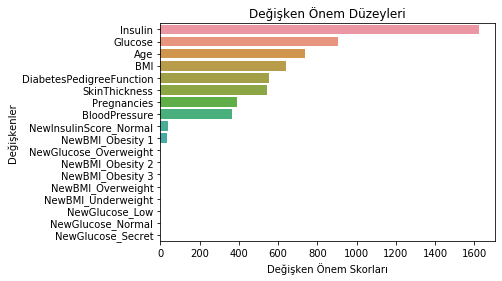

In [71]:
feature_imp = pd.Series(lgbm_tuned.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Değişken Önem Skorları')
plt.ylabel('Değişkenler')
plt.title("Değişken Önem Düzeyleri")
plt.show()

In [83]:
# Tum modellerin train validasyon skorları

models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('XGB', GradientBoostingClassifier()))
models.append(("LightGBM", LGBMClassifier()))

# evaluate each model in turn
results = []
names = []


LR: 0.848684 (0.037332)
KNN: 0.840789 (0.031386)
CART: 0.848684 (0.031825)
RF: 0.880263 (0.031386)
SVM: 0.851316 (0.036772)
XGB: 0.886842 (0.022942)
LightGBM: 0.884211 (0.025514)


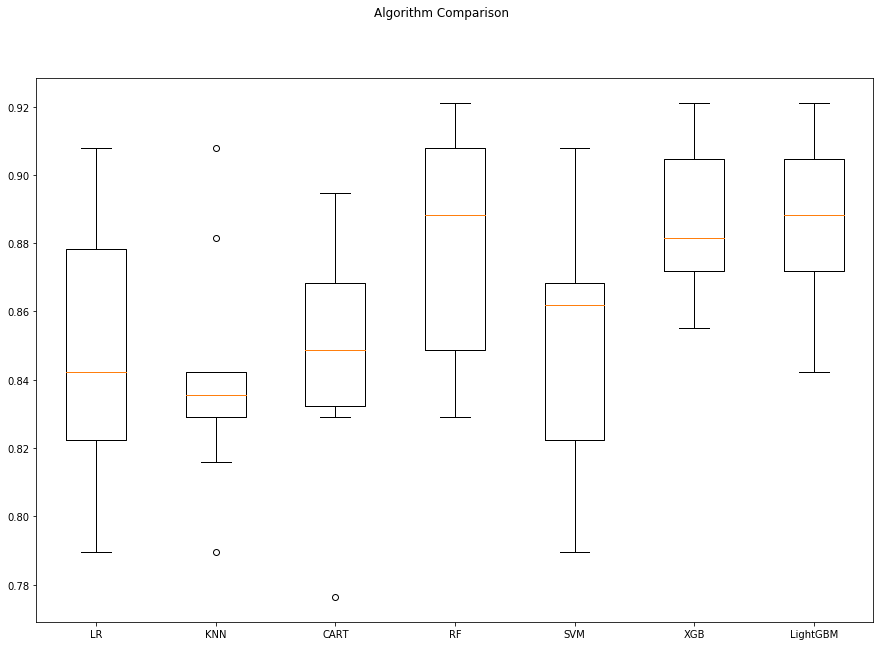

In [84]:

for name, model in models:
    
        kfold = KFold(n_splits = 10, random_state = 123456)
        cv_results = cross_val_score(model, X, y, cv = 10, scoring= "accuracy")
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

LR: 0.851995 (0.026383)
KNN: 0.863470 (0.025746)
CART: 0.843716 (0.042480)
RF: 0.876557 (0.026283)
SVM: 0.858525 (0.019905)
XGB: 0.868388 (0.032923)
LightGBM: 0.879836 (0.028024)


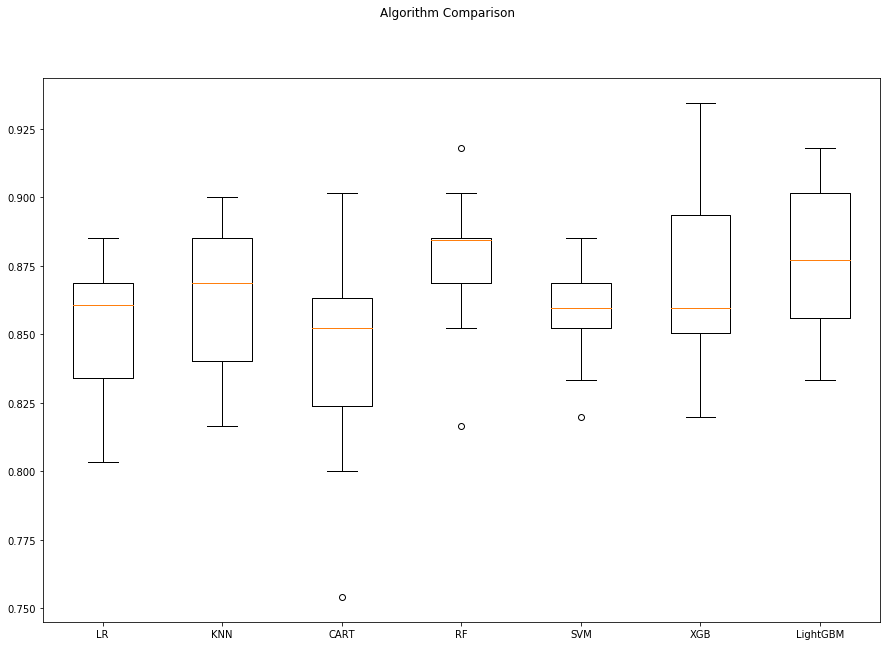

In [85]:
# Tum modellerin train validasyon skorları

models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('XGB', GradientBoostingClassifier()))
models.append(("LightGBM", LGBMClassifier()))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 46)



# evaluate each model in turn
results = []
names = []

for name, model in models:
    
        kfold = KFold(n_splits = 10, random_state = 123456)
        cv_results = cross_val_score(model, X_train, y_train, cv = kfold, scoring= "accuracy")
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
 
